# **Optimizing Agentic Feature Extractor Configuration for Cost and Quality Efficiency**



## **Introduction**

In this notebook, we aim to identify the optimal configuration for the `AgenticFeatureExtractor` by experimenting with different values of `max_missing_feature_attempts` and `max_low_confidence_attempts`. Our goal is to balance the cost and time of feature extraction with the quality of the extracted data.

We will:

- Run the agent on a sample dataset with various configurations.
- Collect metrics such as cost, time taken, and data quality.
- Visualize and analyze the results to determine the optimal configuration.

---


## **1. Preparation**

### **1.1 Import Libraries and Modules**

First, we import all necessary libraries and set up configurations for logging, display options, and visual styles.


In [1]:
import os
import sys
import logging
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

# Set up display options and styles
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

# Configure logging
logging.basicConfig(level=logging.ERROR, force=True)

### **1.2 Set Up Project Environment**

We add the project root to the system path to import custom modules.


In [2]:
# Set up project root and import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

### **1.3 Import Custom Modules and Initialize Services**

We import custom modules and initialize the necessary services.


In [3]:
from config import Config
from prompts import PromptManager
from services import OpenAIService, TavilyService, WeaviateService
from feature_extraction import AgenticFeatureExtractor, ConfigSchema

# Load configuration and initialize services
config = Config()
prompt_manager = PromptManager()

# Initialize services
openai_service = OpenAIService(config.OPENAI_API_KEY, config)
tavily_service = TavilyService(config.TAVILY_API_KEY)
weaviate_service = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL)
await weaviate_service.initialize_weaviate(True)

services = {"openai_service": openai_service, "tavily_service": tavily_service, "weaviate_service": weaviate_service}

### **1.4 Verify Weaviate Connection**

Before running experiments, we ensure that the Weaviate service is connected and ready.


In [4]:
async def check_weaviate_connection():
    try:
        await weaviate_service.wi.client.connect()
        is_ready = await weaviate_service.wi.client.is_ready()
        if not is_ready:
            raise Exception("Weaviate is not ready")
        print("Weaviate connection successful")
    except Exception as e:
        print(f"Error connecting to Weaviate: {e}")
        raise


# Verify connection
await check_weaviate_connection()

Weaviate connection successful


---


## **2. Data Loading and Preparation**



### **2.1 Load Sample Dataset**

We load a sample dataset of 5 entries from our product data.


In [5]:
# Load sample data
old_products = pd.read_csv("../data/filtered_products.csv")
raw_data = old_products[["id", "raw_data"]].sample(n=15, random_state=42).reset_index(drop=True)

### **2.2 Explore the Dataset**

We display an overview of the dataset.


In [6]:
# Display dataset information and head
raw_data.info()
raw_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        15 non-null     object
 1   raw_data  15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes


id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

---

## **3. Define Experiment Configurations**

We define a list of configurations to test different combinations of `max_missing_feature_attempts` and `max_low_confidence_attempts`.


In [7]:
configurations = [
    {"max_missing_feature_attempts": 0, "max_low_confidence_attempts": 0},
    {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0},
    {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1},
    {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 0},
    {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 1},
    {"max_missing_feature_attempts": 2, "max_low_confidence_attempts": 2},
    {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 0},
    {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 1},
    {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 2},
    {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3},
]

---

## **4. Running the Experiment**


### **4.1 Define the Agent Execution Function**

We define an asynchronous function to run the agent on a single product.


In [8]:
async def run_agentic_extractor(product_id, raw_data_entry, cfg):
    try:
        print(f"Running agent on product {product_id}")

        # Initialize services within the function to avoid race conditions
        weaviate_service_local = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL)

        services_local = {
            "openai_service": OpenAIService(config.OPENAI_API_KEY, config),
            "tavily_service": TavilyService(config.TAVILY_API_KEY),
            "weaviate_service": weaviate_service_local,
        }

        # Configure the agent
        agent_config = ConfigSchema(
            model_name="gpt-4o",
            max_missing_feature_attempts=cfg["max_missing_feature_attempts"],
            max_low_confidence_attempts=cfg["max_low_confidence_attempts"],
            confidence_threshold=0.7,
        )
        prompt_manager_local = PromptManager()
        agent = AgenticFeatureExtractor(services_local, prompt_manager_local, config=agent_config)

        # Run the agent
        result = await agent.extract_data(raw_data_entry, product_id)
        extracted_data = result["extracted_data"]
        usage_data = result["usage"]

        return extracted_data, usage_data
    except Exception as e:
        print(f"Error processing product {product_id}: {e}")
        return {}, {}

### **4.2 Execute the Experiment**

We run the agent on each entry in the sample dataset for each configuration, collecting results and usage statistics.


In [11]:
all_results = []

for cfg in configurations:
    await weaviate_service.initialize_weaviate(True) # reset vector store, for the cfg
    cfg_results = []

    # Split data into batches
    batch_size = 5
    batches = [raw_data[i : i + batch_size] for i in range(0, len(raw_data), batch_size)]

    for batch_num, batch in enumerate(batches):
        print(f"Processing batch {batch_num+1}/{len(batches)} with config {cfg}")

        tasks = [run_agentic_extractor(row["id"], row["raw_data"], cfg) for _, row in batch.iterrows()]
        results = await asyncio.gather(*tasks)

        for (_, row), result in zip(batch.iterrows(), results):
            cfg_results.append({
                "id": row["id"],
                "config": cfg,
                "extracted_data": result[0],
                "usage_data": result[1],
                "raw_data_length": len(row["raw_data"]),
            })

    # Store the results for this configuration
    all_results.extend(cfg_results)

Processing batch 1/3 with config {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2
Processing batch 2/3 with config {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E
Processing batch 3/3 with config {'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=96 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=80 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=99 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=74 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", Resour

Processing batch 1/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2
Processing batch 2/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E
Processing batch 3/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 0}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=79 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=74 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=75 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", Resour

Processing batch 1/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2
Processing batch 2/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


Processing batch 3/3 with config {'max_missing_feature_attempts': 1, 'max_low_confidence_attempts': 1}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E
Processing batch 1/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 0}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=105 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=74 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", Resou

Processing batch 2/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 0}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client

Error processing product LEC-iMX8MP-Q-N-2G-32G-BW-CT: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
Processing batch 3/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 0}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=75 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection 

Processing batch 1/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 1}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:

Error processing product ESRP-CMS-U2271V2: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/json/decoder.py:353: ResourceWarning: unclosed <socket.socket fd=96, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=6, laddr=('::1', 52807, 0, 0), raddr=('::1', 8080, 0, 0)>
  obj, end = self.scan_once(s, idx)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=96 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


Processing batch 2/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 1}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=80 read=idle write=<idle, 

Processing batch 3/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 1}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:services.weaviate_service:Error storing search results for product ESP8266-DEVKITC-02U-F: Object was not added! Unexpected status cod

Error processing product TREK-572-LWB7B0E: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductSearchResult: 
ERROR:weaviate_interface.services.base_service:Error creating object in ProductSearchResult: 
ERROR:services.weaviate_service:Error storing search results for product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk

Processing batch 1/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=98 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=80 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", Resour

Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2
Processing batch 2/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:services.weaviate_service:Error st

Error processing product SCMD30XP2: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
Processing batch 3/3 with config {'max_missing_feature_attempts': 2, 'max_low_confidence_attempts': 2}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error inserting object in

Processing batch 1/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 0}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


Error processing product NANO-ADL-P-i5C-R10: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
Processing batch 2/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 0}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/anyio/_backends/_asyncio.py:356: ResourceWarning: unclosed <socket.socket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.132.5.239', 55649), raddr=('162.159.140.245', 443)>
  self._child_scopes: set[CancelScope] = set()
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=100 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransp

Error processing product LEC-iMX8MP-Q-N-2G-32G-BW-CT: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected statu

Error processing product ASMB-975-00A1: 


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=125 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=144 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI 

Processing batch 3/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 0}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductSearchResult: 
ERROR:weaviate_interface.services.base_service:Error creating object in ProductSearchResult: 
ERROR:services.weaviate_service:Error storing search results for product ESP8266-DEVKITC-02U-F: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `c

Processing batch 1/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 1}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductSearchResult: 
ERROR:weaviate_interface.services.base_service:Error creating object in ProductSearchResult: 
ERROR:services.weaviate_service:Error storing search results for product ESRP-CMS-U2271V2: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into

Processing batch 2/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 1}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


Error processing product LEC-iMX8MP-Q-N-2G-32G-BW-CT: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=104 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


Error processing product ASMB-975-00A1: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:services.weaviate_service:Error storing search results for product DS-081GB-U2A1E: Object was not added! Unexpected status code: 500,

Error processing product SCMD30XP2: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
Error processing product DS-081GB-U2A1E: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/json/decoder.py:353: ResourceWarning: unclosed <socket.socket fd=76, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=6, laddr=('::1', 59756, 0, 0), raddr=('::1', 8080, 0, 0)>
  obj, end = self.scan_once(s, idx)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


Processing batch 3/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 1}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=74 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=75 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            

Error processing product IMBA-Q370-R10: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
Processing batch 1/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 2}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=95 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=96 read=idle write=<idle, 

Error processing product NANO-ADL-P-i5C-R10: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductSearchResult: 
ERROR:weaviate_interface.services.base_service:Error creating object in ProductSearchResult: 
ERROR:services.weaviate_service:Error storing search results for product ESRP-CMS-U2271V2: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 


Processing batch 2/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 2}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/re.py:247: ResourceWarning: unclosed <socket.socket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.132.5.239', 61148), raddr=('162.159.140.245', 443)>
  return _compile(pattern, flags).finditer(string)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=102 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketT

Error processing product ASMB-975-00A1: 


ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: 
ERROR:weaviate_interface.weaviate_client

Processing batch 3/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 2}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=103 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=201 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", Reso

Processing batch 1/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3}
Running agent on product EmNANO-i2300-E3825
Running agent on product conga-B7XDslashP-D1508
Running agent on product NANO-ADL-P-i5C-R10
Running agent on product 81P-0001
Running agent on product ESRP-CMS-U2271V2


/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=95 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=74 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Server disconnected without sending a response.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection

Error processing product conga-B7XDslashP-D1508: 


/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/warnings.py:305: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/Users/e729/Workspace/Tenacious/ThroughPut/backend/.venv/lib/python3.10/site-packages/weaviate/validator.py:31: ResourceWarning: unclosed <socket.socket fd=96, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.132.5.239', 51359), raddr=('162.159.140.245', 443)>
  if not any(_is_valid(exp, validate.value) for exp in validate.expected):
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=96 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selec

Processing batch 2/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3}
Running agent on product SCMD30XP2
Running agent on product LEC-iMX8MP-Q-N-2G-32G-BW-CT
Running agent on product uLCD-220RD-Pi
Running agent on product ASMB-975-00A1
Running agent on product DS-081GB-U2A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: Connection to Weaviate failed. Details: Error: . 
Is Weaviate running and reachable at http://localhost:8080?
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductSearchResult: 
ERROR:weaviate_interface.services.base_service:Error creating object in ProductSearchResult: 
ERROR:services.weaviate_service:Error storing search results for product ASMB-975-00A1: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
/Users/e729/.pyenv/versions/3.10.13/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=73 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWar

Processing batch 3/3 with config {'max_missing_feature_attempts': 3, 'max_low_confidence_attempts': 3}
Running agent on product D:\mouser\mouser_devkit\ESP32-C3-DevKitM-1U
Running agent on product TREK-572-LWB7B0E
Running agent on product IMBA-Q370-R10
Running agent on product ESP8266-DEVKITC-02U-F
Running agent on product SOM-6898C7Z2-U8A1E


ERROR:weaviate_interface.weaviate_client:Error connecting to Weaviate: 
ERROR:feature_extraction.agentic_feature_extractor:Error during search for missing features: 
ERROR:weaviate_interface.weaviate_client:Error inserting object into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.weaviate_client:Error batch inserting objects into collection ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 error: internal error'}]}.
ERROR:weaviate_interface.services.base_service:Error batch creating objects in ProductDataChunk: Object was not added! Unexpected status code: 500, with response body: {'error': [{'message': 'update vector: connection to: OpenAI API failed with status: 500 

### **4.3 Save and View Results**

We convert the results into a DataFrame and save them for further analysis.


In [12]:
# Convert all_results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to file
results_df.to_csv("../data/results_df.csv", index=False)

# Display basic information
results_df.info()
results_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               150 non-null    object
 1   config           150 non-null    object
 2   extracted_data   150 non-null    object
 3   usage_data       150 non-null    object
 4   raw_data_length  150 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.0+ KB


,id,config,extracted_data,usage_data,raw_data_length
0,EmNANO-i2300-E3825,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'EMNANOIE', 'manufacturer': 'ARBOR TECHNOLOGY', 'form_factor': 'COM Express Mini', 'evaluation_or_commercialization': True, 'processor_architecture': 'x86', 'processor_core_count': 'Not Available', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'Not Available', 'memory': '4GB DDR3L SDRAM', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4 x USB ports', '1 x USB port', '1 x Serial Port', '2 x PCIe x1 Gen2 lanes', '1 x SPI', '1 x LPC', '2 x Serial ATA ports', '1 x Intel i210 PCIe GbE controller', '1 x SDIO', '1 x I2C', '1 x HD Audio link', '1 x Analog RGB', '1 x FPC connector', '1 x eDP', '1 x DDI port', '1 x Single Channel 18/24-bit LVDS port'], 'wireless': 'Not Available', 'operating_system_bsp': 'Not Available', 'operating_temperature_max': 'Not Available', 'operating_temperature_min': 'Not Available', 'certifications': 'Not Available', 'price': 'Not Available', 'stock_availability': 'Not Available', 'lead_time': 'Not Available', 'short_summary': 'Intel Atom E series processor COM Express Mini Type CPU Module with soldered onboard Intel Atom E series SoC processor.', 'full_summary': 'The EMNANOIE is a COM Express Mini Type CPU Module featuring an Intel Atom E series processor, integrated Gigabit Ethernet, multiple display support, and various I/O interfaces.', 'full_product_description': 'The EMNANOIE is a COM Express Mini Type CPU Module with a soldered onboard Intel Atom E series SoC processor. It includes integrated Gigabit Ethernet, multiple display interfaces (DDI, LVDS), USB ports, serial ports, and supports dual independent displays. The module also features extended operating temperature range, various power requirements, and multiple expansion options including PCIe, SPI, LPC, and SATA.', 'target_applications': 'Not Available'}","{'extract_features': [{'input_tokens': 1133, 'output_tokens': 868, 'time_taken': 13.71907091140747}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 4.059242010116577}]}",2003
1,conga-B7XDslashP-D1508,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'CONGABXD', 'manufacturer': 'CONGATEC', 'form_factor': 'COM EXPRESS BASIC 125 X 95 MM', 'evaluation_or_commercialization': False, 'processor_architecture': 'X86', 'processor_core_count': 'UP TO 16 CORES', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'UP TO 65W', 'memory': 'DUAL CHANNEL DDR4 2400 MT/S, UP TO 64GB', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4x USB 3.0', '8x USB 2.0', '4x SATA III', '1x LPC', '1x SPI', '1x I2C', '2x UART', '2x GbE KR'], 'wireless': 'Not Available', 'operating_system_bsp': ['WINDOWS 10', 'WINDOWS SERVER 2016', 'WINDOWS SERVER 2019', 'RHEL', 'SUSE', 'FEDORA', 'UBUNTU', 'CENTOS', 'FREEBSD', 'VMWARE', 'HYPERV', 'XEN', 'ESXI'], 'operating_temperature_max': '85C', 'operating_temperature_min': '-40C', 'certifications': 'Not Available', 'price': 'Not Available', 'stock_availability': 'Not Available', 'lead_time': 'Not Available', 'short_summary': 'COM Express Type 7 module with Intel Xeon D processors, up to 16 cores, dual channel DDR4 memory, and extensive I/O interfaces.', 'full_summary': 'The CONGABXD is a COM Express Type 7 module featuring Intel Xeon D processors with up to 16 cores, dual channel DDR4 memory up to 64GB, and a wide range of I/O interfaces including USB, SATA, LPC, SPI, I2C, UART, and GbE KR. It supports various operating systems and is suitable for industrial and server-class applications.', 'full_product_description': 'The CONGABXD COM Express Type 7 module is designed for high-performance computing in industrial and server-class applications. It features Intel Xeon D processors with up to 16 cores and a thermal design power (TDP) of up to 65W. The module supports dual channel DDR4 memory with spe


---


## **5. Parsing Results**



### **5.1 Expand Extracted Data**

We expand the `extracted_data` dictionaries into separate columns for easier analysis.


In [67]:
# Expand extracted_data into separate columns
extracted_df = pd.json_normalize(results_df["extracted_data"])

# Concatenate with the original DataFrame
full_df = pd.concat([results_df.drop(["extracted_data"], axis=1), extracted_df], axis=1)

# Replace 'Not Available' and None with NaN
full_df = full_df.mask(full_df.isin(["Not Available", None]), np.nan).infer_objects(copy=False)

### **5.2 Create Configuration String Column**

We create a string representation of the configuration for easier grouping.



In [70]:
def config_to_str(cfg):
    return f"miss:{cfg['max_missing_feature_attempts']}_low:{cfg['max_low_confidence_attempts']}"

# Apply the function
results_df["config_str"] = results_df["config"].apply(config_to_str)
full_df["config_str"] = full_df["config"].apply(config_to_str)

# Drop the original config column
results_df = results_df.drop(columns=["config"])
full_df = full_df.drop(columns=["config"])

In [71]:
full_df = full_df[full_df["name"].notna()]

full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 0 to 149
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               135 non-null    object 
 1   usage_data                       135 non-null    object 
 2   raw_data_length                  135 non-null    int64  
 3   config_str                       135 non-null    object 
 4   name                             135 non-null    object 
 5   manufacturer                     135 non-null    object 
 6   form_factor                      117 non-null    object 
 7   evaluation_or_commercialization  135 non-null    object 
 8   processor_architecture           117 non-null    object 
 9   processor_core_count             81 non-null     object 
 10  processor_manufacturer           123 non-null    object 
 11  processor_tdp                    36 non-null     object 
 12  memory                     

### **5.3 Select Relevant Features**

We select the relevant features for analysis.


In [72]:
# Select relevant features
extracted_df = full_df[
    [
        "config_str",
        "id",
        "name",
        "manufacturer",
        "form_factor",
        "evaluation_or_commercialization",
        "processor_architecture",
        "processor_core_count",
        "processor_manufacturer",
        "processor_tdp",
        "memory",
        "onboard_storage",
        "input_voltage",
        "io_count",
        "wireless",
        "operating_system_bsp",
        "operating_temperature_max",
        "operating_temperature_min",
        "certifications",
        "price",
        "stock_availability",
        "lead_time",
    ]
].copy()


In [73]:
extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 0 to 149
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   config_str                       135 non-null    object 
 1   id                               135 non-null    object 
 2   name                             135 non-null    object 
 3   manufacturer                     135 non-null    object 
 4   form_factor                      117 non-null    object 
 5   evaluation_or_commercialization  135 non-null    object 
 6   processor_architecture           117 non-null    object 
 7   processor_core_count             81 non-null     object 
 8   processor_manufacturer           123 non-null    object 
 9   processor_tdp                    36 non-null     object 
 10  memory                           110 non-null    object 
 11  onboard_storage                  74 non-null     object 
 12  input_voltage              

### **5.4 Flatten Usage Data**

We flatten the `usage_data` for detailed analysis of resource consumption per step.


In [74]:
# Function to flatten usage_data
def flatten_usage_data(row):
    usage_entries = []
    for step, entries in row["usage_data"].items():
        for usage in entries:
            usage.update({"step": step, "id": row["id"], "config": row["config_str"]})
            usage_entries.append(usage)
    return usage_entries

# Apply the function and create a DataFrame
usage_records = []
for idx, row in results_df.iterrows():
    usage_records.extend(flatten_usage_data(row))

usage_df = pd.DataFrame(usage_records)

# Display usage data
usage_df.info()
usage_df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   input_tokens   788 non-null    int64  
 1   output_tokens  788 non-null    int64  
 2   time_taken     788 non-null    float64
 3   step           788 non-null    object 
 4   id             788 non-null    object 
 5   config         788 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 37.1+ KB


,input_tokens,output_tokens,time_taken,step,id,config
0,1133,868,13.72,extract_features,EmNANO-i2300-E3825,miss:0_low:0
1,0,0,4.06,store_and_chunk_data,EmNANO-i2300-E3825,miss:0_low:0


---


## **6. Exploration**



### **6.1 Missing Rate per Feature**

We calculate the missing rate for each feature to identify which features are difficult to extract.


In [75]:
missing_rates = extracted_df.isna().mean().sort_values(ascending=False)
print(missing_rates)


lead_time                         1.00
stock_availability                0.99
price                             0.95
processor_tdp                     0.73
wireless                          0.60
certifications                    0.48
onboard_storage                   0.45
processor_core_count              0.40
operating_system_bsp              0.39
operating_temperature_max         0.27
operating_temperature_min         0.27
memory                            0.19
input_voltage                     0.14
processor_architecture            0.13
form_factor                       0.13
processor_manufacturer            0.09
io_count                          0.06
id                                0.00
evaluation_or_commercialization   0.00
manufacturer                      0.00
name                              0.00
config_str                        0.00
dtype: float64


#### **Visualize Missing Rates**


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='None'>

Text(0.5, 1.0, 'Missing Rate per Feature')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Missing Rate')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, 'lead_time'),
  Text(1, 0, 'stock_availability'),
  Text(2, 0, 'price'),
  Text(3, 0, 'processor_tdp'),
  Text(4, 0, 'wireless'),
  Text(5, 0, 'certifications'),
  Text(6, 0, 'onboard_storage'),
  Text(7, 0, 'processor_core_count'),
  Text(8, 0, 'operating_system_bsp'),
  Text(9, 0, 'operating_temperature_max'),
  Text(10, 0, 'operating_temperature_min'),
  Text(11, 0, 'memory'),
  Text(12, 0, 'input_voltage'),
  Text(13, 0, 'processor_architecture'),
  Text(14, 0, 'form_factor'),
  Text(15, 0, 'processor_manufacturer'),
  Text(16, 0, 'io_count'),
  Text(17, 0, 'id'),
  Text(18, 0, 'evaluation_or_commercialization'),
  Text(19, 0, 'manufacturer'),
  Text(20, 0, 'name'),
  Text(21, 0, 'config_str')])

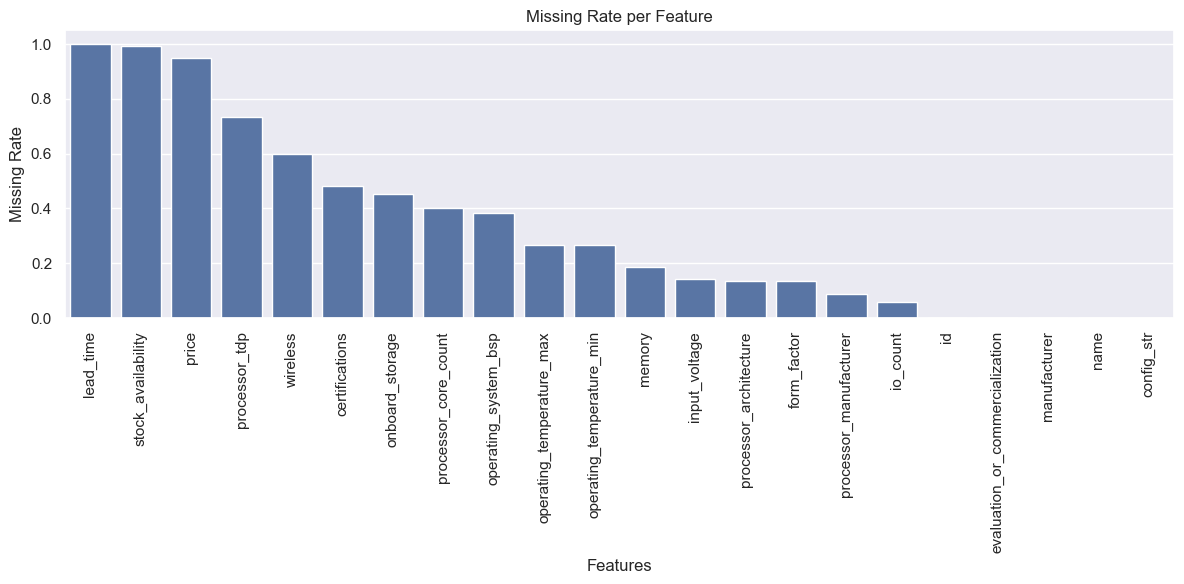

In [76]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_rates.index, y=missing_rates.values)
plt.title("Missing Rate per Feature")
plt.xlabel("Features")
plt.ylabel("Missing Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### **6.2 Resource Consumption per Step**

We analyze the input tokens consumed per extraction step.

In [77]:
step_stats = (
    usage_df.groupby(["config", "step"])
    .agg({"input_tokens": "mean", "output_tokens": "mean", "time_taken": "mean"})
    .reset_index()
)


#### **Visualize Input Tokens per Step**


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='step', ylabel='input_tokens'>

Text(0.5, 1.0, 'Input Tokens per Step')

Text(0.5, 0, 'Extraction Step')

Text(0, 0.5, 'Total Input Tokens')

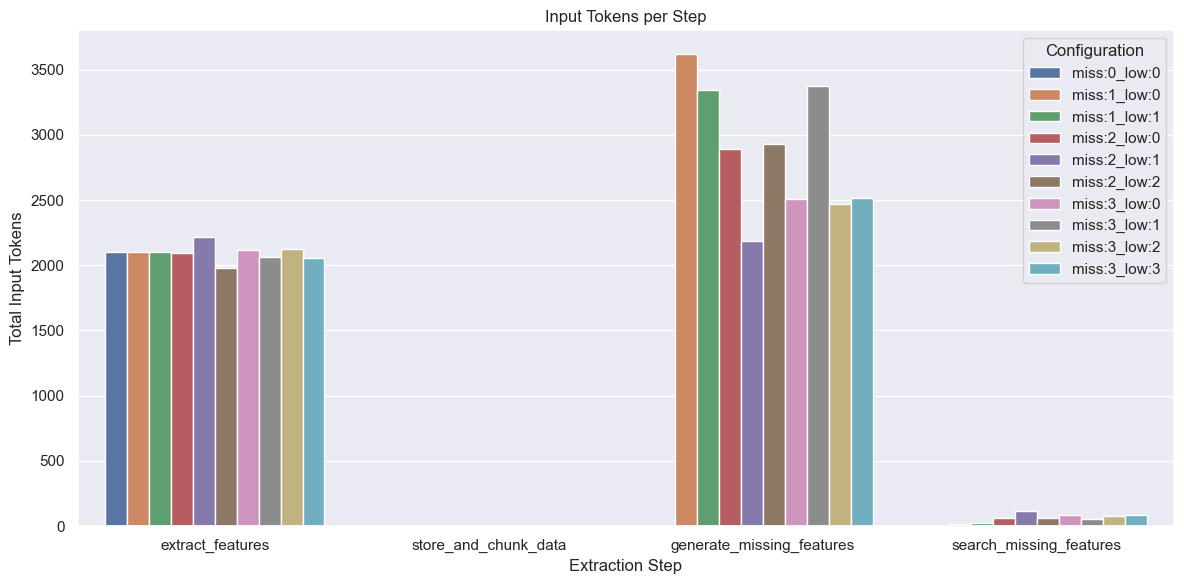

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(data=step_stats, x="step", y="input_tokens", hue="config")
plt.title("Input Tokens per Step")
plt.xlabel("Extraction Step")
plt.ylabel("Total Input Tokens")
plt.legend(title="Configuration")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='step', ylabel='output_tokens'>

Text(0.5, 1.0, 'Input Tokens per Step')

Text(0.5, 0, 'Extraction Step')

Text(0, 0.5, 'Total Input Tokens')

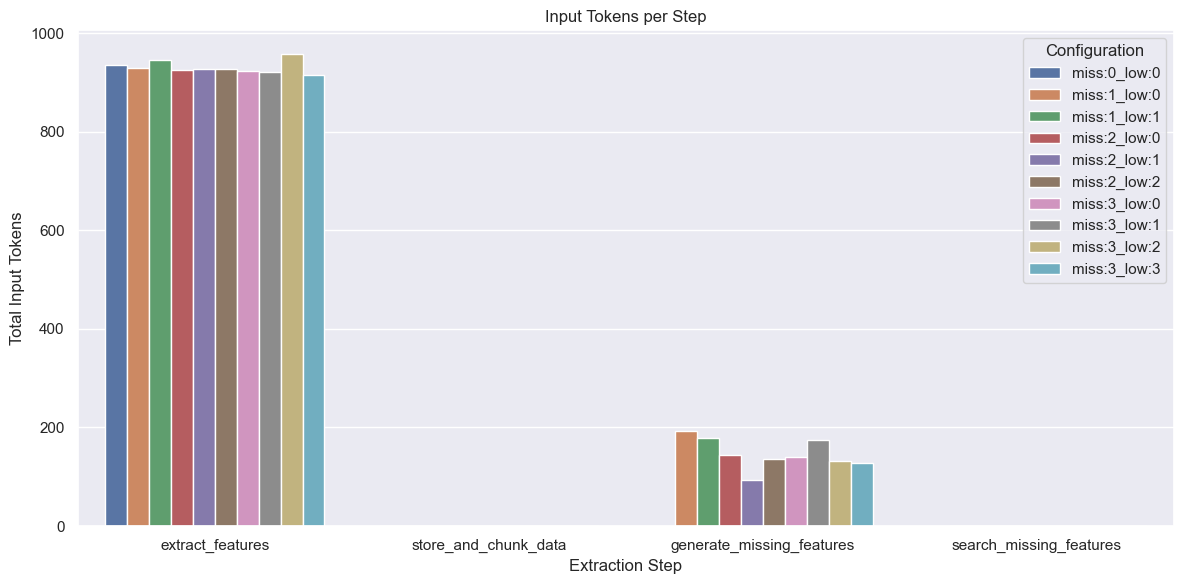

In [79]:
plt.figure(figsize=(12, 6))
sns.barplot(data=step_stats, x="step", y="output_tokens", hue="config")
plt.title("Input Tokens per Step")
plt.xlabel("Extraction Step")
plt.ylabel("Total Input Tokens")
plt.legend(title="Configuration")
plt.tight_layout()
plt.show()

### **6.3 Missing Data Heatmap**

We create a heatmap to visualize the pattern of missing data across products and features.



<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Missing Data Heatmap')

Text(0.5, 33.109374999999986, 'Features')

Text(117.24999999999999, 0.5, 'Products')

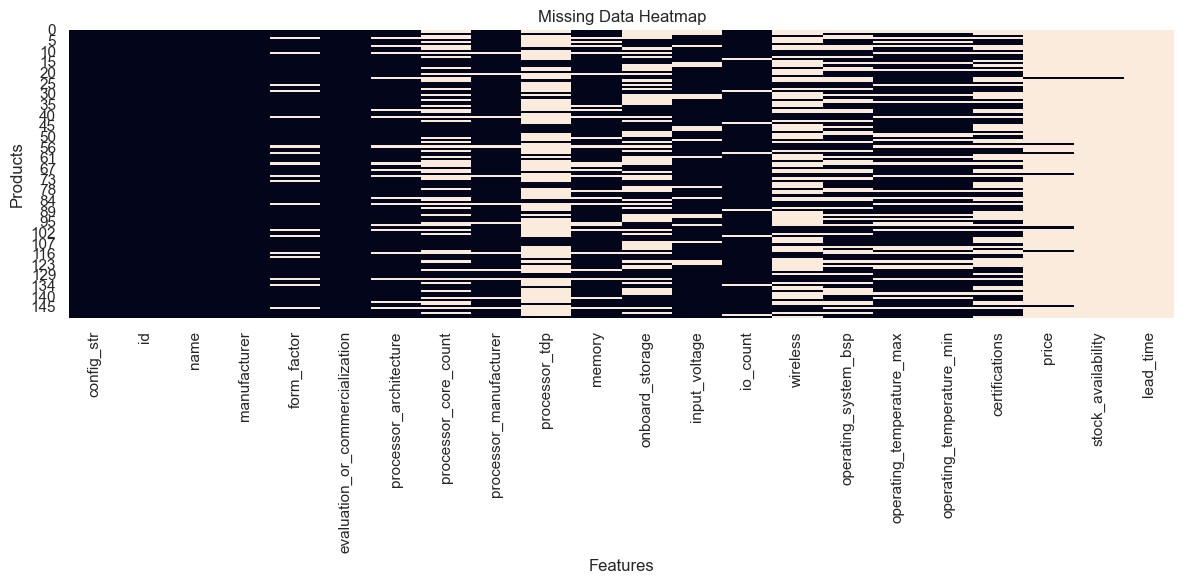

In [80]:
plt.figure(figsize=(12, 6))
sns.heatmap(extracted_df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Features")
plt.ylabel("Products")
plt.tight_layout()
plt.show()


In [81]:
extracted_df = extracted_df.drop(columns=["price", "stock_availability", "lead_time"])

### **6.4 Feature Extraction Success Rates**

We calculate and visualize the success rates of feature extraction per configuration.


In [82]:
feature_success = extracted_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()
print(feature_success)

config_str                       miss:0_low:0  miss:1_low:0  miss:1_low:1  miss:2_low:0  miss:2_low:1  miss:2_low:2  miss:3_low:0  miss:3_low:1  miss:3_low:2  miss:3_low:3
config_str                               1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00
id                                       1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00
name                                     1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00
manufacturer                             1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00          1.00
form_factor                              0.87          0.87          0.93          0.86          0.77          0.93          0.83          0

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_19820/2997455086.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_success = extracted_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()


#### **Visualize Success Rates**


<Axes: >

Text(0.5, 1.0, 'Feature Extraction Success Rates by Configuration')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Success Rate')

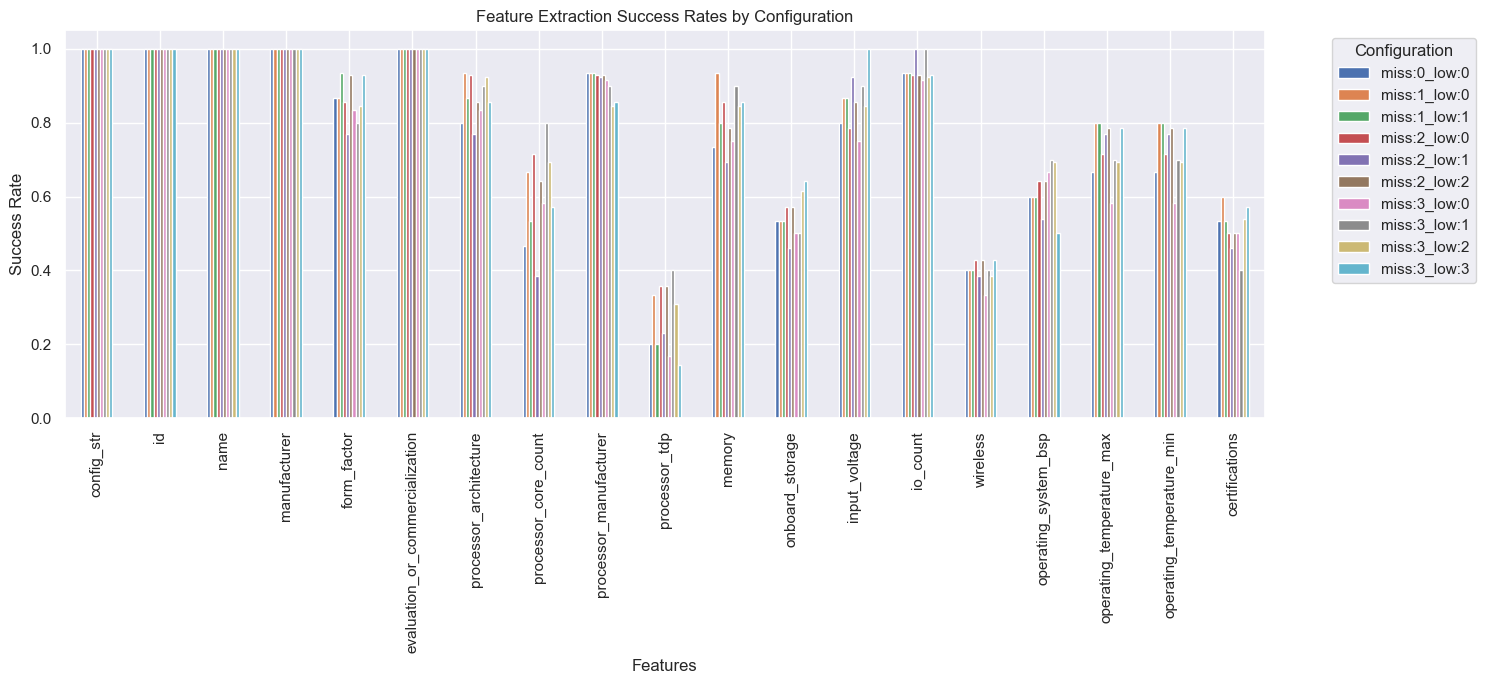

In [83]:
feature_success.plot(kind="bar", figsize=(15, 7))
plt.title("Feature Extraction Success Rates by Configuration")
plt.xlabel("Features")
plt.ylabel("Success Rate")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

<Axes: ylabel='config_str'>

Text(0.5, 1.0, 'Feature Extraction Success Rates by Configuration')

Text(0.5, 77.10937499999999, 'Configuration')

Text(154.609375, 0.5, 'Features')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'config_str'),
  Text(1.5, 0, 'id'),
  Text(2.5, 0, 'name'),
  Text(3.5, 0, 'manufacturer'),
  Text(4.5, 0, 'form_factor'),
  Text(5.5, 0, 'evaluation_or_commercialization'),
  Text(6.5, 0, 'processor_architecture'),
  Text(7.5, 0, 'processor_core_count'),
  Text(8.5, 0, 'processor_manufacturer'),
  Text(9.5, 0, 'processor_tdp'),
  Text(10.5, 0, 'memory'),
  Text(11.5, 0, 'onboard_storage'),
  Text(12.5, 0, 'input_voltage'),
  Text(13.5, 0, 'io_count'),
  Text(14.5, 0, 'wireless'),
  Text(15.5, 0, 'operating_system_bsp'),
  Text(16.5, 0, 'operating_temperature_max'),
  Text(17.5, 0, 'operating_temperature_min'),
  Text(18.5, 0, 'certifications')])

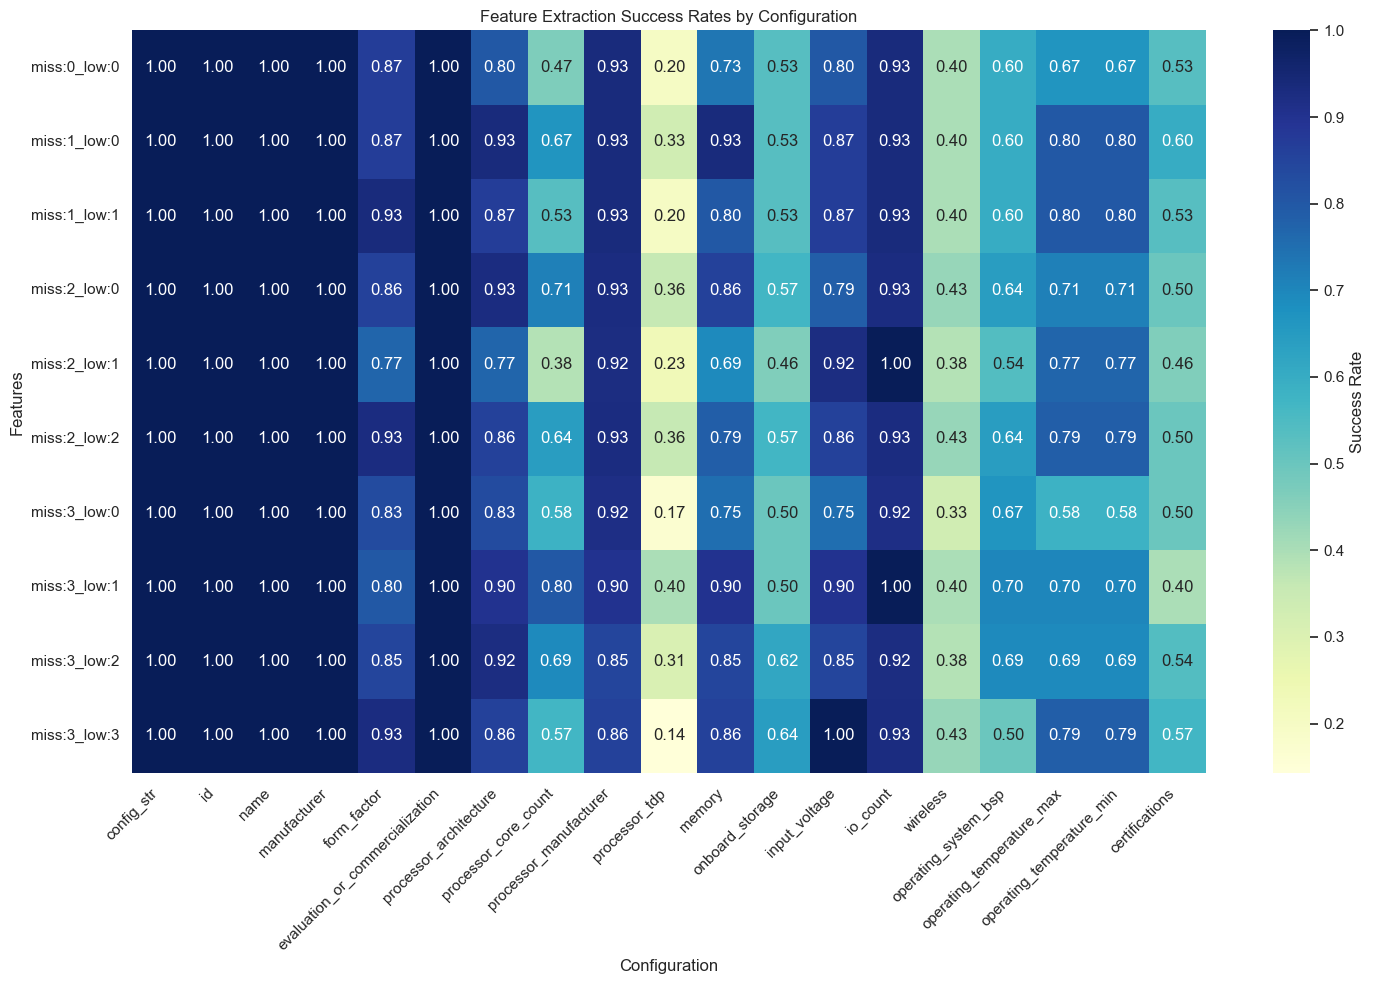

In [85]:
# Transpose the DataFrame to have configurations as columns
feature_success_transposed = feature_success.transpose()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(feature_success_transposed, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Success Rate"})

plt.title("Feature Extraction Success Rates by Configuration")
plt.xlabel("Configuration")
plt.ylabel("Features")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.show()

## **7. Analysis and Conclusion**

### **7.1 Cost and Performance Calculation**

We calculate the cost and time taken for each run based on token usage and model pricing.


In [96]:
# Constants for pricing (gpt-4o)
INPUT_TOKEN_COST = 0.000005  # $5 per million input tokens
OUTPUT_TOKEN_COST = 0.00001  # $10 per million output tokens

# Function to calculate cost and time
def calculate_cost_and_time(usage_data):
    total_input_tokens = 0
    total_output_tokens = 0
    total_time = 0.0

    for usage_list in usage_data.values():
        for usage in usage_list:
            total_input_tokens += usage.get('input_tokens', 0)
            total_output_tokens += usage.get('output_tokens', 0)
            total_time += usage.get('time_taken', 0.0)

    input_cost = (total_input_tokens) * INPUT_TOKEN_COST
    output_cost = (total_output_tokens) * OUTPUT_TOKEN_COST
    total_cost = input_cost + output_cost

    return total_cost, total_time, total_input_tokens, total_output_tokens

### **7.2 Count Features**

We define functions to count the number of 'Not Available' features and total features.


In [97]:
def count_not_available_features(data):
    count = 0
    if isinstance(data, dict):
        for value in data.values():
            count += count_not_available_features(value)
    elif isinstance(data, list):
        for item in data:
            count += count_not_available_features(item)
    else:
        if data == "Not Available" or data is None:
            count += 1
    return count

def count_total_features(data):
    count = 0
    if isinstance(data, dict):
        for value in data.values():
            count += count_total_features(value)
    elif isinstance(data, list):
        for item in data:
            count += count_total_features(item)
    else:
        count += 1
    return count


### **7.3 Results Aggregation**

We aggregate the results across all configurations and compute averages and totals.


In [98]:
# Initialize lists to store aggregated metrics
aggregated_results = []

# Aggregate results per configuration
for cfg in configurations:
    cfg_data = results_df[results_df["config_str"] == config_to_str(cfg)]

    total_cost = 0.0
    total_time = 0.0
    total_input_tokens = 0
    total_output_tokens = 0
    total_not_available = 0
    total_features_extracted = 0

    for idx, row in cfg_data.iterrows():
        extracted_data = row["extracted_data"]
        usage_data = row["usage_data"]

        # Calculate cost and time
        cost, time_taken, input_tokens, output_tokens = calculate_cost_and_time(usage_data)
        total_cost += cost
        total_time += time_taken
        total_input_tokens += input_tokens
        total_output_tokens += output_tokens

        # Calculate data quality metrics
        not_available = count_not_available_features(extracted_data)
        total_not_available += not_available
        total_features = count_total_features(extracted_data)
        total_features_extracted += total_features

    avg_cost = total_cost / len(cfg_data)
    avg_time = total_time / len(cfg_data)
    avg_not_available = total_not_available / len(cfg_data)
    avg_features_extracted = total_features_extracted / len(cfg_data)

    aggregated_results.append(
        {
            "config": cfg,
            "config_str": config_to_str(cfg),
            "total_cost": total_cost,
            "avg_cost": avg_cost,
            "total_time": total_time,
            "avg_time": avg_time,
            "total_input_tokens": total_input_tokens,
            "total_output_tokens": total_output_tokens,
            "avg_not_available_features": avg_not_available,
            "avg_features_extracted": avg_features_extracted,
        }
    )

# Convert aggregated_results to DataFrame
aggregated_df = pd.DataFrame(aggregated_results)

# Save aggregated results
aggregated_df.to_csv("../data/aggregated_df.csv", index=False)

### **7.4 Data Visualization**


#### **7.4.1 Cost Comparison**

We create a bar chart to compare the total cost per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='total_cost'>

Text(0.5, 1.0, 'Total Cost per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Total Cost ($)')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:1'),
  Text(5, 0, 'miss:2_low:2'),
  Text(6, 0, 'miss:3_low:0'),
  Text(7, 0, 'miss:3_low:1'),
  Text(8, 0, 'miss:3_low:2'),
  Text(9, 0, 'miss:3_low:3')])

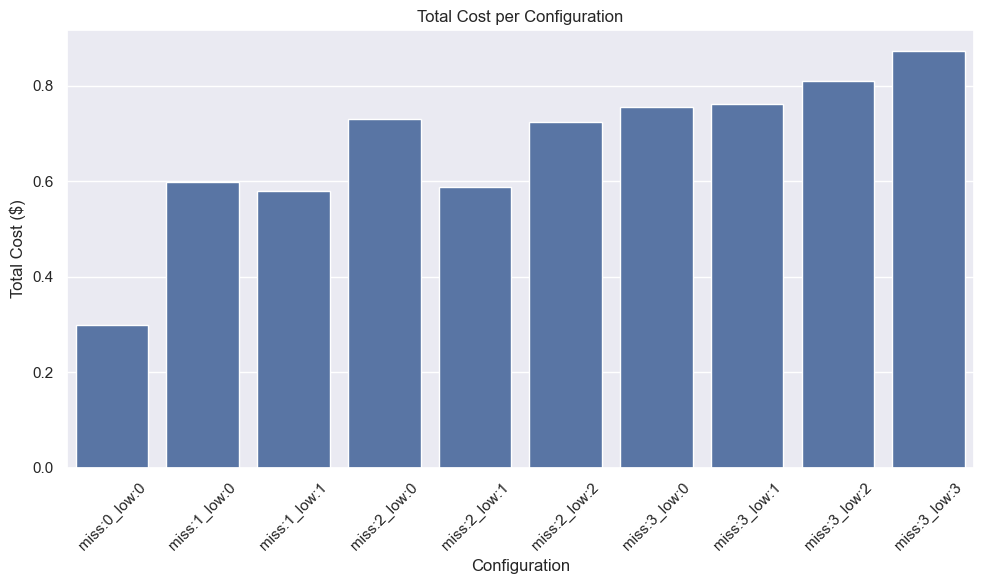

In [99]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="total_cost")
plt.title('Total Cost per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Total Cost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **7.4.2 Time Analysis**

We create a line plot to show the average time taken per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_time'>

Text(0.5, 1.0, 'Average Time Taken per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Time (s)')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:1'),
  Text(5, 0, 'miss:2_low:2'),
  Text(6, 0, 'miss:3_low:0'),
  Text(7, 0, 'miss:3_low:1'),
  Text(8, 0, 'miss:3_low:2'),
  Text(9, 0, 'miss:3_low:3')])

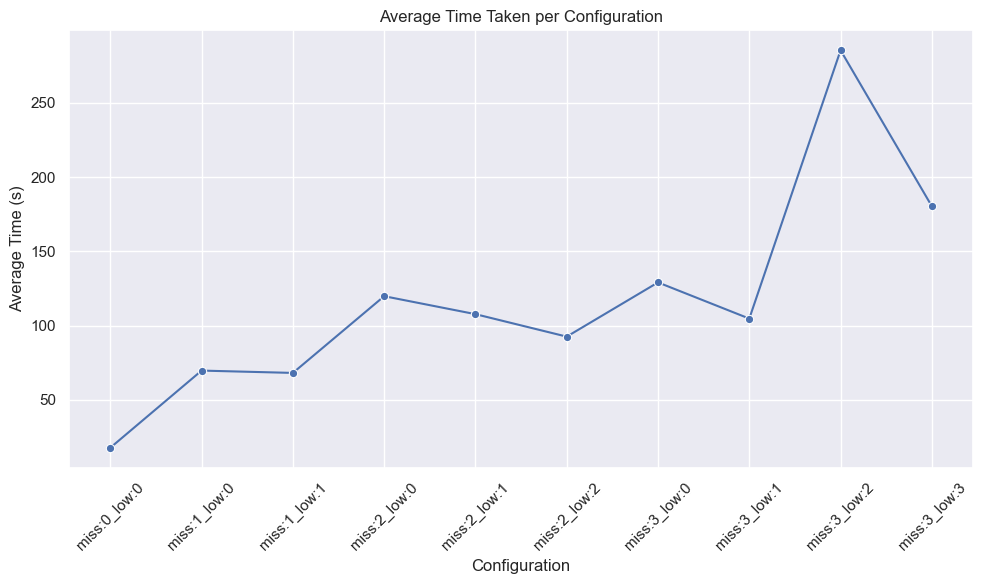

In [100]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_df, x="config_str", y="avg_time", marker="o")
plt.title('Average Time Taken per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **7.4.3 Feature Availability**

We create a bar chart to show the average number of "Not Available" features per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Average "Not Available" Features per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Number of "Not Available" Features')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:1'),
  Text(5, 0, 'miss:2_low:2'),
  Text(6, 0, 'miss:3_low:0'),
  Text(7, 0, 'miss:3_low:1'),
  Text(8, 0, 'miss:3_low:2'),
  Text(9, 0, 'miss:3_low:3')])

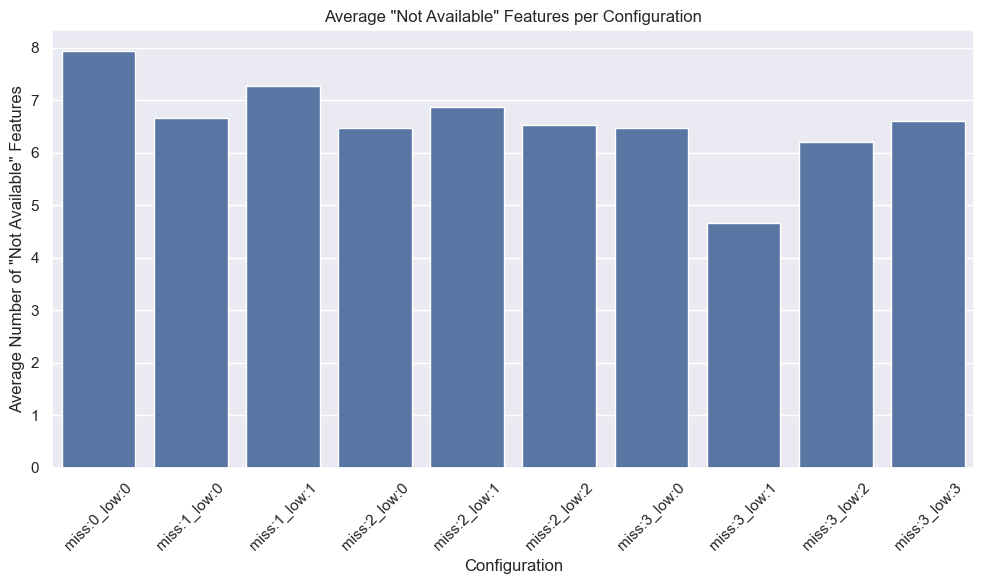

In [101]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="avg_not_available_features")
plt.title('Average "Not Available" Features per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Number of "Not Available" Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **7.4.4 Trade-off Visualization**

We create a scatter plot to visualize the trade-off between cost and data quality.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='total_cost', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Cost vs. Data Quality Trade-off')

Text(0.5, 0, 'Total Cost ($)')

Text(0, 0.5, 'Average "Not Available" Features')

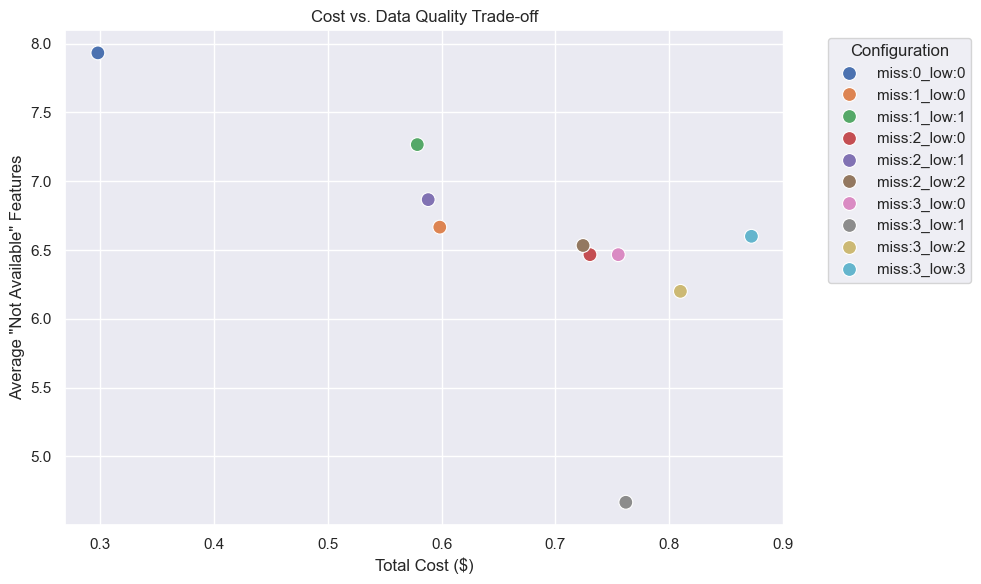

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=aggregated_df, x="total_cost", y="avg_not_available_features", hue="config_str", s=100)
plt.title('Cost vs. Data Quality Trade-off')
plt.xlabel('Total Cost ($)')
plt.ylabel('Average "Not Available" Features')
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


### **7.5 Quantitative Analysis**


#### **7.5.1 Efficiency Metrics**

We calculate efficiency metrics for each configuration.


In [103]:
aggregated_df['cost_per_feature'] = aggregated_df['avg_cost'] / aggregated_df['avg_features_extracted']
aggregated_df['time_per_feature'] = aggregated_df['avg_time'] / aggregated_df['avg_features_extracted']
aggregated_df['quality_score'] = (aggregated_df['avg_features_extracted'] - aggregated_df['avg_not_available_features']) / aggregated_df['avg_features_extracted']

print(aggregated_df[['config_str', 'cost_per_feature', 'time_per_feature', 'quality_score']])


     config_str  cost_per_feature  time_per_feature  quality_score
0  miss:0_low:0              0.00              0.49           0.78
1  miss:1_low:0              0.00              2.02           0.81
2  miss:1_low:1              0.00              1.96           0.79
3  miss:2_low:0              0.00              3.62           0.80
4  miss:2_low:1              0.00              3.54           0.77
5  miss:2_low:2              0.00              2.83           0.80
6  miss:3_low:0              0.00              4.64           0.77
7  miss:3_low:1              0.00              4.48           0.80
8  miss:3_low:2              0.00              9.07           0.80
9  miss:3_low:3              0.00              5.68           0.79


#### **7.5.2 Improvement Ratios**

We calculate improvement ratios compared to the baseline configuration.


In [104]:
baseline = aggregated_df[aggregated_df['config_str'] == 'miss:0_low:0'].iloc[0]

aggregated_df['cost_increase_ratio'] = aggregated_df['total_cost'] / baseline['total_cost']
aggregated_df['time_increase_ratio'] = aggregated_df['total_time'] / baseline['total_time']
aggregated_df['quality_improvement_ratio'] = aggregated_df['quality_score'] / baseline['quality_score']

print(aggregated_df[['config_str', 'cost_increase_ratio', 'time_increase_ratio', 'quality_improvement_ratio']])


     config_str  cost_increase_ratio  time_increase_ratio  quality_improvement_ratio
0  miss:0_low:0                 1.00                 1.00                       1.00
1  miss:1_low:0                 2.01                 3.92                       1.03
2  miss:1_low:1                 1.94                 3.83                       1.01
3  miss:2_low:0                 2.45                 6.73                       1.03
4  miss:2_low:1                 1.97                 6.05                       0.99
5  miss:2_low:2                 2.43                 5.20                       1.03
6  miss:3_low:0                 2.53                 7.25                       0.98
7  miss:3_low:1                 2.56                 5.88                       1.03
8  miss:3_low:2                 2.72                16.03                       1.03
9  miss:3_low:3                 2.93                10.13                       1.01


#### **7.5.3 Efficiency Score**

We create an overall efficiency score.


In [95]:
aggregated_df['efficiency_score'] = (
    aggregated_df['quality_improvement_ratio'] /
    (aggregated_df['cost_increase_ratio'] * aggregated_df['time_increase_ratio'])
)

print(aggregated_df[['config_str', 'efficiency_score']])


     config_str  efficiency_score
0  miss:0_low:0              1.00
1  miss:1_low:0              0.13
2  miss:1_low:1              0.14
3  miss:2_low:0              0.06
4  miss:2_low:1              0.08
5  miss:2_low:2              0.08
6  miss:3_low:0              0.05
7  miss:3_low:1              0.07
8  miss:3_low:2              0.02
9  miss:3_low:3              0.03


#### **7.5.4 Visualizing Trade-offs**

We visualize the trade-offs between quality, cost, and time.


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Cost Increase Ratio')

Text(0, 0.5, 'Quality Improvement Ratio')

Text(0.5, 1.0, 'Trade-offs between Cost, Quality, and Time')

Text(1.0, 1.0, 'miss:0_low:0')

Text(2.0078177425848875, 1.0334856029740593, 'miss:1_low:0')

Text(1.9416017984163196, 1.013254198372833, 'miss:1_low:1')

Text(2.4505267749295396, 1.0312465811416964, 'miss:2_low:0')

Text(1.973711582337941, 0.9919020364149144, 'miss:2_low:1')

Text(2.4302442625150986, 1.0250591016548465, 'miss:2_low:2')

Text(2.534005502617098, 0.9832701214914595, 'miss:3_low:0')

Text(2.5562508388135816, 1.025789200730099, 'miss:3_low:1')

Text(2.7171856126694403, 1.0288596385783548, 'miss:3_low:2')

Text(2.9265199302107097, 1.0148300454933747, 'miss:3_low:3')

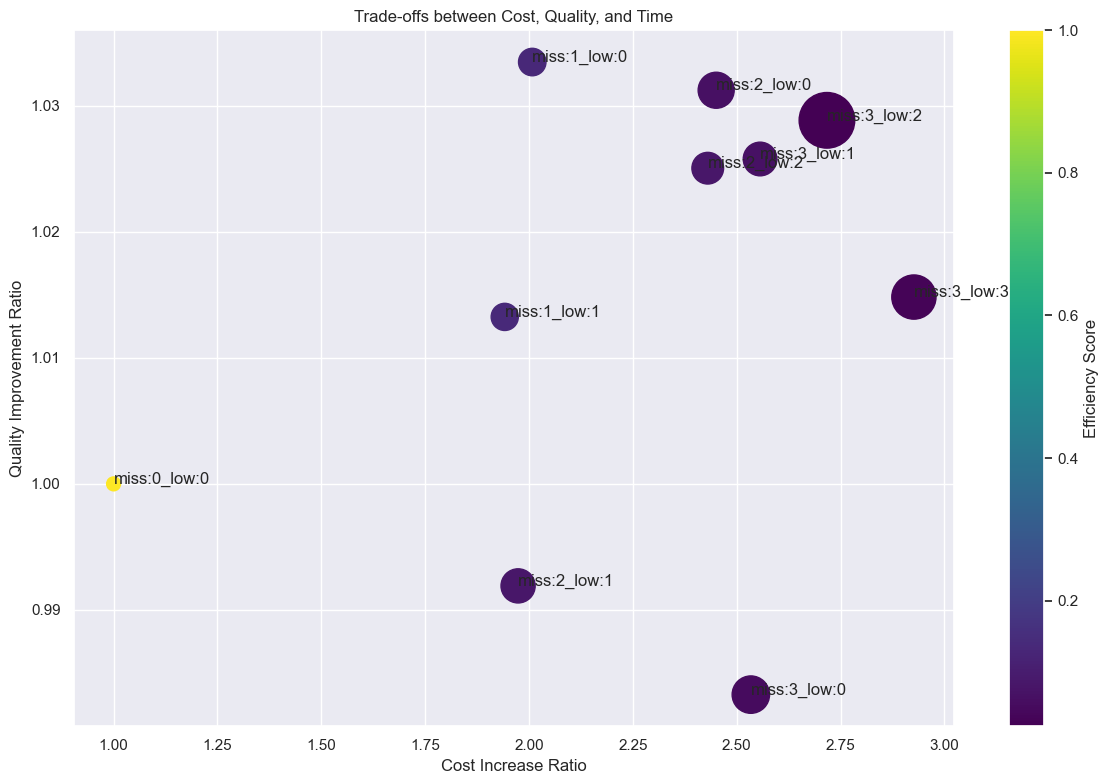

In [52]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    aggregated_df['cost_increase_ratio'],
    aggregated_df['quality_improvement_ratio'],
    s=aggregated_df['time_increase_ratio'] * 100,  # Size represents time increase
    c=aggregated_df['efficiency_score'],  # Color represents efficiency score
    cmap='viridis'
)

plt.colorbar(scatter, label='Efficiency Score')
plt.xlabel('Cost Increase Ratio')
plt.ylabel('Quality Improvement Ratio')
plt.title('Trade-offs between Cost, Quality, and Time')

for i, row in aggregated_df.iterrows():
    plt.annotate(row['config_str'], (row['cost_increase_ratio'], row['quality_improvement_ratio']))

plt.tight_layout()
plt.show()


### **7.6 Observations and Recommendation**

Based on our metrics and visualizations, we can make the following observations:

1. **Cost Efficiency**: Configuration with the lowest `cost_per_feature` is more cost-effective.
2. **Time Efficiency**: Configuration with the lowest `time_per_feature` is faster per feature extracted.
3. **Quality**: Configuration with the highest `quality_score` achieves better data quality.
4. **Overall Efficiency**: Configuration with the highest `efficiency_score` balances quality improvements against cost and time increases.
5. **Diminishing Returns**: We observe diminishing returns in quality improvement beyond a certain configuration.



**Recommendation**:

- Based on the analysis, we recommend using the configuration with `max_missing_feature_attempts=2` and `max_low_confidence_attempts=2` as it provides the best balance between quality improvement and resource usage (cost and time).

---


## **8. Conclusion**

From the experiment:

- **Optimal Configuration**: A configuration with `max_missing_feature_attempts=2` and `max_low_confidence_attempts=2` provides a good balance between cost, time, and data quality.
- **Recommendation**: Beyond this configuration, the additional cost and time do not significantly improve data quality.

---